In [1]:
%cd ../../src


e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src


In [2]:
from dataload import dmg777k
data = dmg777k()
from utils import get_p_types,get_relevant_relations,RDF_NUMBER_TYPES
#p_types = get_p_types(data)
rr = get_relevant_relations(data, RDF_NUMBER_TYPES)


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loaded data dmg777k (64.07s).
pruned (9.963s).


In [3]:
#Kullback-Leibler (KL) divergence
import math
import numpy as np
def adapted_kl_divergence(p_dist_a,p_dist_b, num_bins = 10):
    a_bin = np.histogram(p_dist_a.val,num_bins)[0]
    b_bin = np.histogram(p_dist_b.val,num_bins)[0]
    a_len = len(p_dist_a.val)
    b_len = len(p_dist_b.val)
    sum_l =0
    e = 0.1**10
    for i in range(len(a_bin)):
        sum_l += np.log((a_bin[i]/(b_bin[i]+e))+e)*a_bin[i]
    return round(b_len/a_len * sum_l , 5)

In [4]:
from kgbench.load import Data
import torch
import pandas as pd
def get_relations_for_entites(data:Data,entities):
    df = data.triples
    df = df[torch.isin(df[:,0], torch.tensor(entities))]
    r, counts = torch.unique(df[:,1], return_counts=True)
    return pd.DataFrame({'r':r.numpy(),'count':counts.numpy()}).sort_values('count',ascending=False).reset_index(drop=True)

In [5]:
from kgbench.load import Data


def bin_on_subpopulations_short(data:Data, base_relation:int, strategy = 'relations', max_depth=2):
    triples = data.triples
    relevant_triples = triples[triples[:,1] == base_relation]
    s_list = [[relevant_triples[:,0].numpy()]] # list with subject for each level of tree
    #get all subjects possessing relation 'base_relation'
    df = pd.DataFrame(relevant_triples[:,0], columns=['s']) 
    ## add val column containing numerical values coresponding to the s base_relation o triple, then mapped according to i2e[o]
    df['val'] = df.s.apply(lambda s: int(data.i2e[relevant_triples[relevant_triples[:,0]==s][0,2]][0]))

    r_counts = get_relations_for_entites(data, df.s)
    r_counts = r_counts[r_counts['r']!=base_relation] # here better logic is needed


    for i in range(max_depth-1):
        sub_s_list = [] 
        found = False
        j = 0
        while not found:
            sub_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[j].r][:,0])]
            proportion = len(sub_triples)/len(relevant_triples)
            #print(proportion)
            if proportion>0.95 or proportion <0.05:
                j += 1
            #df[df.s.isin(s_list[0][0])]['val']
            elif adapted_kl_divergence(df[df.s.isin(s_list[0][0])], df[df.s.isin(sub_triples[:,0].numpy())])<100:
                j+=1
            else:
                sub_s_list.append(sub_triples[:,0].numpy())
                #isin = torch.isin(relevant_triples[:,0], sub_triples[:,0])
                #neg = relevant_triples[~torch.isin(relevant_triples[:,0], sub_triples[:,0])]
                sub_s_list.append(relevant_triples[~torch.isin(relevant_triples[:,0], sub_triples[:,0])][:,0].numpy())
                found = True

                #print(len(df[df.s.isin(s_list[0][0])]))
                #print(df[df.s.isin(sub_triples[:,0].numpy())])

                

            #print('kl_div')
            #print(adapted_kl_divergence(df[df.s.isin(s_list[0][0])], df[df.s.isin(sub_triples[:,0].numpy())]))
            #if j >= len(r_counts)-1:
            #    found = True
            #if len(sub_triples)/len(relevant_triples)<0.01 or len(sub_triples)/len(triples)>0.99:
            #    i+=1 #skip to next
            #else:
            #    break

        s_list.append(sub_s_list)
        break

    #    else:
    #        found =True
        
    #sub_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[-1].r][:,0] )]# find overlapping
    #sub_s_list.append(sub_triples[:,0].numpy())
    #sub_s_list.append(triples[~torch.isin(triples[:,0],sub_triples[:,0])][:,0].numpy())
    #s_list.append(sub_s_list)
    return df, s_list

    #print(sub_triples)
    #sub_df = pd.DataFrame(sub_triples[:,0], columns=['s']) 
    #sub_df['val'] = sub_df.s.apply(lambda s: int(data.i2e[sub_triples[sub_triples[:,0]==s][0,2]][0]))

    #print(r_counts.iloc[0].r)
    ##print(sub)
    #print(len(sub))
    #print(len(df))
    #return sub_df


In [34]:
from kgbench.load import Data


def bin_on_subpopulations(data:Data, base_relation:int, strategy = 'relations', max_depth=2):
    #get triples
    triples = data.triples
    relevant_triples = triples[triples[:,1] == base_relation]
    
    s_list = [[relevant_triples[:,0].numpy()]] # list with subject for each level of tree
    #get all subjects possessing relation 'base_relation'
    df = pd.DataFrame(relevant_triples[:,0], columns=['s']) 
    ## add val column containing numerical values coresponding to the s base_relation o triple, then mapped according to i2e[o]
    df['val'] = df.s.apply(lambda s: int(float(data.i2e[relevant_triples[relevant_triples[:,0]==s][0,2]][0])))

    #calculate and sort most common relations among entities 
    r_counts = get_relations_for_entites(data, df.s)
    r_counts = r_counts[r_counts['r']!=base_relation] # here better logic is needed


    for i in range(1): # not yet implemented for deeper walks
        parent = s_list[0][0]
        print(len(parent))
        c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], torch.tensor(parent) )] #same as relavant triples
        print(len(c_triples))
        print(c_triples)
        #child_reminder = parent
        
        sub_s_list = [] 
        #found = False
        #j = 0

        for j in range(len(r_counts)):
            #c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], child_reminder )]

            sub_triples = triples[(triples[:,1] == base_relation) & (torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[j].r][:,0])) & (torch.isin(triples[:,0], c_triples[:,0]))]
            proportion = len(sub_triples)/len(parent)
            kl_div = adapted_kl_divergence(df[df.s.isin(c_triples[:,0].numpy())], df[df.s.isin(sub_triples[:,0].numpy())])
            
            print(f'j: {j} - prop: {proportion} - kl_div: {kl_div}')

            if proportion>0.95 or proportion <0.05:
                pass
            #need to define value here
            elif kl_div<300:
                pass
            else:
                #print("was here")
                print("added")
                sub_s_list.append(sub_triples[:,0].numpy())
                c_triples = c_triples[~torch.isin(c_triples[:,0],sub_triples[:,0])]

        sub_s_list.append(c_triples[:,0].numpy())
        if len(sub_s_list) >1:
            s_list.append(sub_s_list)
    return df, s_list


In [ ]:
adapted_kl_divergence(df[df.s.isin(c_triples[:,0].numpy())], df[df.s.isin(sub_triples[:,0].numpy())])

,s,val
0,192538,111805
1,192573,36188
2,192579,20476
3,192607,10410
4,192617,6559
...,...,...
505,199839,19141
506,199852,22991
507,199975,1496
508,199979,5814


In [21]:
relevant_triples = data.triples[data.triples[:,1] == rr[0]]
    
s_list = [[relevant_triples[:,0].numpy()]] 

In [27]:
c_triples = data.triples[(data.triples[:,1] == rr[0]) & torch.isin(data.triples[:,0], torch.tensor(s_list[0][0]) )]

In [32]:
r_counts

NameError: name 'r_counts' is not defined

In [31]:
len(c_triples)

510

In [6]:
rr

[26, 2, 43]

In [38]:
df, s_list = bin_on_subpopulations(data,rr[1])



8396
8396
tensor([[272082,      2,    420],
        [272084,      2,    510],
        [272086,      2,    530],
        ...,
        [288868,      2,  18471],
        [288870,      2,  18474],
        [288872,      2,  18476]], dtype=torch.int32)
j: 0 - prop: 1.0 - kl_div: 0.0
j: 1 - prop: 1.0 - kl_div: 0.0
j: 2 - prop: 1.0 - kl_div: 0.0
j: 3 - prop: 1.0 - kl_div: 0.0
j: 4 - prop: 1.0 - kl_div: 0.0
j: 5 - prop: 1.0 - kl_div: 0.0
j: 6 - prop: 1.0 - kl_div: 0.0
j: 7 - prop: 1.0 - kl_div: 0.0
j: 8 - prop: 1.0 - kl_div: 0.0
j: 9 - prop: 1.0 - kl_div: 0.0
j: 10 - prop: 1.0 - kl_div: 0.0
j: 11 - prop: 0.17317770366841354 - kl_div: 3743.86096
added
j: 12 - prop: 0.0 - kl_div: 0.0
j: 13 - prop: 0.11434016198189614 - kl_div: 1942.76852
added
j: 14 - prop: 0.0 - kl_div: 0.0
j: 15 - prop: 0.0 - kl_div: 0.0
j: 16 - prop: 0.011314911862791805 - kl_div: 462.51359
j: 17 - prop: 0.011314911862791805 - kl_div: 462.51359
j: 18 - prop: 0.012505955216769891 - kl_div: 436.96134
j: 19 - prop: 0.003692234397

In [48]:
from typing import List, Sequence, Tuple
def encode_number_sublist(df: torch.Tensor, i2e: List[str]) -> torch.Tensor:
    sub_df = df.clone()
    for i in range(len(sub_df)):
        sub_df[i, 1] = torch.tensor(
            float(i2e[sub_df[i, 2]][0]), dtype=torch.float32)
    sub_df = sub_df[:, :2]
    return sub_df
def delete_empty_bin_types(data: Data, num_bins:int)-> Data:
    to_delete= []
    for d in data.i2e[-num_bins:]:
        filtered = data.triples[data.triples[:,2]==data.e2i[d]]
        if len(filtered) == 0:
            to_delete.append(data.e2i[d])

    if(len(to_delete)!=0):
        #to_delete_i = [data.e2i[d] in]
        print(f"deleting relations {to_delete}, since no occurences are given")
                #create new e mapping
        new_e2i = {}
        new_i2e = []

        for i in range(len(data.i2e)):
            if i not in to_delete:
                nt = torch.tensor(len(new_i2e), dtype=torch.int32)
                it = torch.tensor(i, dtype=torch.int32)
                new_e2i[data.i2e[it]] = nt
                new_i2e.append(data.i2e[it])
                # apply new mapping for triples
        for t in data.triples:
            t[0] = new_e2i[data.i2e[t[0]]]
            #t[1] = torch.tensor(data.r2i[data.i2r[t[1].numpy()]], dtype=torch.int32)
            t[2] = new_e2i[data.i2e[t[2]]]

            # create new train & withheld

            #update metedata
        data.num_entities = len(new_i2e)

        data.i2e = new_i2e
        data.e2i = new_e2i
        print('done deleteing')
        print(data.name)
    return data    


In [ ]:
    relevent_relations = get_relevant_relations(
        data, relevant_types=RDF_NUMBER_TYPES)
    #print(num_bins)
    for num_bins in list_num_bins:
        for b in range(num_bins):
            o = (f'{URI_PREFIX}entity#binning{b+1}#num_bins{num_bins}', f'{URI_PREFIX}datatype#bin')
            new_id = len(data.i2e)
            data.e2i[o] = new_id
            data.i2e.append(o)
            data.num_entities += 1

    for num_bins in list_num_bins:
        for r in relevent_relations:
            p = f'{URI_PREFIX}predicat#binning{r}#num_bins{num_bins}'
            new_id = len(data.i2r)
            data.r2i[p] = new_id
            data.i2r.append(p)
            data.num_relations += 1
            
    for num_bins in list_num_bins:
        for relation in relevent_relations:

            sub_df = encode_number_sublist(
                data.triples[data.triples[:, 1] == relation], data.i2e)

        # # TODO test new function
        # if (use_lof):
        #     lof = LocalOutlierFactor(n_neighbors=10)
        #     lof.fit(sub_df[:, 1].reshape(-1, 1))
        #     outlier_scores = lof.negative_outlier_factor_
        #     # Create a new column in the numpy array to store the outlier scores
        #     # tensor_np = torch.hstack((encoded_df, outlier_scores.reshape(-1,1)))
        #     threshold = np.percentile(outlier_scores, 10)
        #     # use the outlier scores to filter out the outliers from the numpy array
        #     sub_df = sub_df[outlier_scores > threshold]

            # numpy is used here since torch.histc was not working for some reason.
            sub_df = torch.cat(  # put bins and sub_df together
                (sub_df, torch.from_numpy(  # get numpy solutions back
                    np.digitize(  # assign for each value in sub_df the corresponding bin
                        sub_df[:, 1], np.histogram(  # calculate n bins based on values in sub_df
                            sub_df[:, 1], num_bins)[1][:-1]
                    )
                ).reshape(-1, 1)  # transfrom x tensor into (x,1) tensor to fit (x,2) shape of sub_df
                ), 1)

            object_mapping = np.vectorize(lambda t: data.e2i[(
                f'{URI_PREFIX}entity#binning{t}#num_bins{num_bins}', f'{URI_PREFIX}datatype#bin')])

            predicat_mapping = np.vectorize(
                lambda t: data.r2i[f'{URI_PREFIX}predicat#binning{relation}#num_bins{num_bins}'])

            sub_df[:, 1] = torch.tensor(np.array([predicat_mapping(sub_df[:, 2])]), dtype=torch.int32)
            sub_df[:, 2] = torch.tensor(np.array([object_mapping(sub_df[:, 2])]), dtype=torch.int32)
            data.triples = torch.cat((data.triples, sub_df), 0)
    data = delete_empty_bin_types(data,np.sum(list_num_bins))
    return data

In [49]:
from utils import URI_PREFIX
num_bins = 10

relevent_relations = get_relevant_relations(data, RDF_NUMBER_TYPES)
for b in range(num_bins):
    o = (f'{URI_PREFIX}entity#binning{b+1}', f'{URI_PREFIX}datatype#bin')
    new_id = len(data.i2e)
    data.e2i[o] = new_id
    data.i2e.append(o)
    data.num_entities += 1

for rr in relevent_relations:
    df, s_list = bin_on_subpopulations(data,rr)
    if len(s_list)>1:
        for i in range(len(s_list[1])):
            p = f'{URI_PREFIX}predicat#binning{rr}#subpopulation{i}'
            new_id = len(data.i2r)
            data.r2i[p] = new_id
            data.i2r.append(p)
            data.num_relations += 1
            
        sub_df = encode_number_sublist(
            data.triples[data.triples[:, 1] == rr], data.i2e)
        
        for i in range(len(s_list[1])):
            
            sub_population_df = sub_df[torch.isin(sub_df[:,0],torch.Tensor(s_list[1][i]))].clone()
            print(f'len subpopulation {len(sub_population_df)}')
            sub_population_df = torch.cat(  # put bins and sub_df together
                (sub_population_df, torch.from_numpy(  # get numpy solutions back
                    np.digitize(  # assign for each value in sub_df the corresponding bin
                    sub_population_df[:, 1], np.histogram(  # calculate n bins based on values in sub_df
                        sub_population_df[:, 1], num_bins)[1][:-1]
                        )
                    ).reshape(-1, 1)  # transfrom x tensor into (x,1) tensor to fit (x,2) shape of sub_df
                ), 1)

            object_mapping = np.vectorize(lambda t: data.e2i[(
                f'{URI_PREFIX}entity#binning{t}', f'{URI_PREFIX}datatype#bin')])

            predicat_mapping = np.vectorize(
                lambda t: data.r2i[f'{URI_PREFIX}predicat#binning{rr}#subpopulation{i}'])

            sub_population_df[:, 1] = torch.tensor(np.array([predicat_mapping(sub_population_df[:, 2])]), dtype=torch.int32)
            sub_population_df[:, 2] = torch.tensor(np.array([object_mapping(sub_population_df[:, 2])]), dtype=torch.int32)
            data.triples = torch.cat((data.triples, sub_population_df), 0)
data = delete_empty_bin_types(data,num_bins)


510
510
tensor([[192538,     26,   1241],
        [192573,     26,   9787],
        [192579,     26,   4910],
        ...,
        [199975,     26,   2068],
        [199979,     26,  15012],
        [199983,     26,   4875]], dtype=torch.int32)
j: 0 - prop: 0.7784313725490196 - kl_div: 100.03431
added
j: 1 - prop: 0.11372549019607843 - kl_div: 52.25175
j: 2 - prop: 0.22156862745098038 - kl_div: 0.0
j: 3 - prop: 0.22156862745098038 - kl_div: 0.0
j: 4 - prop: 0.22156862745098038 - kl_div: 0.0
j: 5 - prop: 0.22156862745098038 - kl_div: 0.0
j: 6 - prop: 0.22156862745098038 - kl_div: 0.0
j: 7 - prop: 0.22156862745098038 - kl_div: 0.0
j: 8 - prop: 0.22156862745098038 - kl_div: 0.0
j: 9 - prop: 0.22156862745098038 - kl_div: 0.0
j: 10 - prop: 0.22156862745098038 - kl_div: 0.0
j: 11 - prop: 0.22156862745098038 - kl_div: 0.0
j: 12 - prop: 0.22156862745098038 - kl_div: 0.0
j: 13 - prop: 0.22156862745098038 - kl_div: 0.0
j: 14 - prop: 0.22156862745098038 - kl_div: 0.0
j: 15 - prop: 0.0 - kl_div: 0

In [ ]:
data.i2r

In [57]:
data.i2e[341276]

('http://master-thesis.com/entity#binning7',
 'http://master-thesis.com/datatype#bin')

In [50]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [288824,     68, 341275],
        [288858,     68, 341277],
        [288866,     68, 341276]])

In [44]:
for i in range(len(s_list[1])):
    for j in range(len(s_list[1])):
        akld = adapted_kl_divergence(df[df.s.isin(s_list[1][i])], df[df.s.isin(s_list[1][j])])
        print(f'kl for {i} to {j}: {akld}')

kl for 0 to 0: 0.0
kl for 0 to 1: 1765.76749
kl for 0 to 2: 8866.07077
kl for 1 to 0: 929.98026
kl for 1 to 1: 0.0
kl for 1 to 2: -10154.81989
kl for 2 to 0: 3999.87615
kl for 2 to 1: 1821.67358
kl for 2 to 2: 0.0


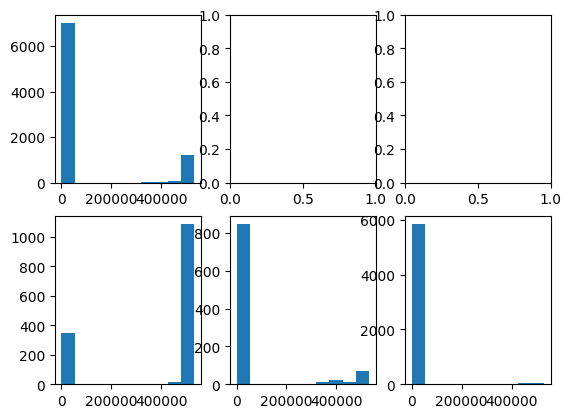

In [45]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(len(s_list), len(s_list[-1]))
for i in range(len(s_list)):
    for j in range(len(s_list[i])):
        axis[i,j].hist(df[df.s.isin(s_list[i][j])]['val'],bins=10)

In [10]:
torch.unique(data.triples[:,1])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59], dtype=torch.int32)

In [11]:
data.i2e[2701]

('1696', 'http://www.w3.org/2001/XMLSchema#gYear')

In [12]:
data.triples[(data.triples[:,0]== 272394) & (data.triples[:,1]== rr[2])]

tensor([[272394,     43,   2701]], dtype=torch.int32)

In [13]:
df

,s,val
0,272102,1884
1,272394,1696
2,272516,1739
3,272540,1650
4,272540,1650
...,...,...
1795,288766,1985
1796,288780,1980
1797,288824,1714
1798,288858,1850


In [2]:
import matplotlib.pyplot as plt

plt.hist(df.val)

NameError: name 'df' is not defined

In [7]:
from utils import  delete_triple

In [12]:
len(data.triples)

768728

In [51]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [53]:
data.triples.numpy()[0,0]

130685

In [54]:
int(data.triples[0,0].numpy())

130685

In [7]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [8]:

data.triples[0,2].numpy()

array(54795)

In [9]:
[2,3]
min([2,3])

2

In [28]:
for i in range(500):
    data = delete_triple(data,data.triples[0,0],data.triples[0,1],data.triples[0,2])


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

In [11]:
len(data.triples[(data.triples[:,0]==data.triples[0,0])])

2

In [12]:
data.i2e[2000]

('1462 HR', 'none')

In [13]:
data.e2i[data.i2e[2000]]

2000

In [31]:
data.num_relations

60

In [29]:
len(data.triples)

776554

In [48]:
rr = get_relevant_relations(data, RDF_NUMBER_TYPES)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Noctris\AppData\Local\Temp\ipykernel_24508\3647624605.py", line 1, in <module>
    rr = get_relevant_relations(data, RDF_NUMBER_TYPES)
  File "e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src\utils\data_utils.py", line 85, in get_relevant_relations
  File "e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src\utils\data_utils.py", line 71, in get_p_types
    for triple in data.triples:
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\IPython\core\interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_tracebac

In [55]:
def delete_all_p_triples(data, pi):
    triples = data.triples
    for t in triples[triples[:,1] == pi]:
        data = delete_triple(data,t[0],t[1],t[2])

In [56]:
data.datatypes()

['iri',
 'none',
 '@es',
 '@fy',
 '@nl',
 '@nl-nl',
 '@pt',
 '@ru',
 'http://kgbench.info/dt#base64Image',
 'http://www.opengis.net/ont/geosparql#wktLiteral',
 'http://www.w3.org/2001/XMLSchema#anyURI',
 'http://www.w3.org/2001/XMLSchema#boolean',
 'http://www.w3.org/2001/XMLSchema#gYear',
 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger',
 'http://www.w3.org/2001/XMLSchema#positiveInteger']

In [57]:
for r in rr:
    delete_all_p_triples(data,r)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

TypeError: list indices must be integers or slices, not str

In [11]:
data.datatypes()

['iri',
 'none',
 '@es',
 '@fy',
 '@nl',
 '@nl-nl',
 '@pt',
 '@ru',
 'http://kgbench.info/dt#base64Image',
 'http://www.opengis.net/ont/geosparql#wktLiteral',
 'http://www.w3.org/2001/XMLSchema#anyURI',
 'http://www.w3.org/2001/XMLSchema#boolean',
 'http://www.w3.org/2001/XMLSchema#gYear',
 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger',
 'http://www.w3.org/2001/XMLSchema#positiveInteger']

In [37]:
data.r2i["http://www.w3.org/2001/XMLSchema#positiveInteger"]


KeyError: 'http://www.w3.org/2001/XMLSchema#positiveInteger'

In [39]:
rr

[26, 2, 43]

In [6]:
len(data.triples[data.triples[:,1]== 2])

8396

In [4]:
rr

[26, 2, 43]

In [10]:
data.i2r[2]

'http://dbpedia.org/ontology/location'

In [9]:
i=0
while("http://dbpedia.org/ontology/codeNationalMonument" in data.r2i):
    if i%200:
        print(i)
    t = data.triples[data.triples[:,1]== data.r2i["http://dbpedia.org/ontology/codeNationalMonument"]]
    data = delete_triple(data,t[0,0], t[0,1], t[0,2] )


TypeError: list indices must be integers or slices, not str

In [13]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [16]:
triples = data.triples
triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [25]:
filtered = triples[~(triples[:,1]==rr[0])]

In [28]:
import torch

In [55]:
s = torch.unique(filtered[:,2])

In [40]:
st = torch.unique(triples[:,2])

In [41]:
neg_filter =  st[~(torch.isin(st, s))]


In [45]:
for n in neg_filter.numpy():
    print(n)
    break

417


In [60]:
filtered[:,2]

tensor([ 54795, 201822,  58948,  ..., 211084, 211084, 211084],
       dtype=torch.int32)

In [64]:
torch.unique(torch.cat([filtered[:,0],filtered[:,2]])) 

tensor([     0,      1,      2,  ..., 341267, 341268, 341269],
       dtype=torch.int32)

In [73]:
def delete_r(data:Data, r):
    # get subset data
    filtered = data.triples[~(data.triples[:,1]==r)]
    # get neg e filter
    base_e_unique = torch.unique(torch.cat([data.triples[:,0],data.triples[:,2]])) 
    filtered_e_unique = torch.unique(torch.cat([filtered[:,0],filtered[:,2]])) 
    neg_e_filter =  base_e_unique[~(torch.isin(base_e_unique, filtered_e_unique))]

    #get neg r filter
    base_r_unique = torch.unique(data.triples[:,1])
    filtered_r_unique = torch.unique(filtered[:,1])
    neg_r_filter =  base_r_unique[~(torch.isin(base_r_unique, filtered_r_unique))]

    #create new e mapping
    new_e2i = {}
    new_i2e = []

    for i in range(len(data.i2e)):
        if i not in neg_e_filter.numpy():
            new_e2i[data.i2e[i]] = len(new_i2e)
            new_i2e.append(data.i2e[i])

    #create new r mapping
    new_r2i = {}
    new_i2r = []

    for i in range(len(data.i2r)):
        if i not in neg_r_filter.numpy():
            new_r2i[data.i2r[i]] = len(new_i2r)
            new_i2r.append(data.i2r[i])

    # apply new mapping for triples
    for t in filtered:
        t[0] = torch.tensor(new_e2i[data.i2e[t[0].numpy()]], dtype=torch.int32)
        t[1] = torch.tensor(new_r2i[data.i2r[t[1].numpy()]], dtype=torch.int32)
        t[2] = torch.tensor(new_e2i[data.i2e[t[2].numpy()]], dtype=torch.int32)

    #update metedata
    data.num_entities = len(new_i2e)
    data.num_relations = len(new_i2r)

    #update data
    data.triples = filtered
    data.i2e = new_i2e
    data.e2i = new_e2i
    data.i2r = new_i2r
    data.r2i = new_r2i
    
    return data



In [80]:
rr = get_relevant_relations(data,RDF_NUMBER_TYPES)

In [81]:
rr

[41]

In [82]:
print(data.num_entities)
print(data.num_relations)
data = delete_r(data, rr[0])
print(data.num_entities)
print(data.num_relations)

332379
58
332089
57


In [75]:
print(data.num_entities)
print(data.num_relations)

340775
59


In [51]:
len(neg_filter)

495

In [50]:
len(data.i2e)

341270

In [19]:
triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [92]:
data.triples[torch.isin(data.triples[:,0], torch.tensor([121501,280064]))]

tensor([[280064,      0,  43028],
        [280064,     26,  46719],
        [280064,     29, 192641],
        [280064,     29, 192642],
        [121501,     29, 192641]], dtype=torch.int32)

In [88]:
torch.unique(data.triples[:,0])

tensor([121500, 121501, 121502,  ..., 280064, 280065, 280066],
       dtype=torch.int32)

In [ ]:
## bin on subpopulation nr 2


In [ ]:
def bin_on_subpopulations(data:Data, base_relation:int, strategy = 'relations', max_depth=2):
    #get triples
    triples = data.triples
    relevant_triples = triples[triples[:,1] == base_relation]
    
    s_list = [[relevant_triples[:,0].numpy()]] # list with subject for each level of tree
    #get all subjects possessing relation 'base_relation'
    df = pd.DataFrame(relevant_triples[:,0], columns=['s']) 
    ## add val column containing numerical values coresponding to the s base_relation o triple, then mapped according to i2e[o]
    df['val'] = df.s.apply(lambda s: int(float(data.i2e[relevant_triples[relevant_triples[:,0]==s][0,2]][0])))

    #calculate and sort most common relations among entities 
    r_counts = get_relations_for_entites(data, df.s)
    r_counts = r_counts[r_counts['r']!=base_relation] # here better logic is needed


    for i in range(1): # not yet implemented for deeper walks
        parent = s_list[0][0]
        print(len(parent))
        c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], torch.tensor(parent) )] #same as relavant triples
        print(len(c_triples))
        print(c_triples)
        #child_reminder = parent
        
        sub_s_list = [] 
        #found = False
        #j = 0

        for j in range(len(r_counts)):
            #c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], child_reminder )]

            sub_triples = triples[(triples[:,1] == base_relation) & (torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[j].r][:,0])) & (torch.isin(triples[:,0], c_triples[:,0]))]
            proportion = len(sub_triples)/len(parent)
            kl_div = adapted_kl_divergence(df[df.s.isin(c_triples[:,0].numpy())], df[df.s.isin(sub_triples[:,0].numpy())])
            
            print(f'j: {j} - prop: {proportion} - kl_div: {kl_div}')

            if proportion>0.95 or proportion <0.05:
                pass
            #need to define value here
            elif kl_div<300:
                pass
            else:
                #print("was here")
                print("added")
                sub_s_list.append(sub_triples[:,0].numpy())
                c_triples = c_triples[~torch.isin(c_triples[:,0],sub_triples[:,0])]

        sub_s_list.append(c_triples[:,0].numpy())
        if len(sub_s_list) >1:
            s_list.append(sub_s_list)
    return df, s_list

In [6]:
rr = get_relevant_relations(data, RDF_NUMBER_TYPES)

In [57]:
base_relation= rr[1]

In [58]:
triples = data.triples
relevant_triples = triples[triples[:,1] == base_relation]
    
s_list = [[relevant_triples[:,0].numpy()]] # list with subject for each level of tree
    #get all subjects possessing relation 'base_relation'
df = pd.DataFrame(relevant_triples[:,0], columns=['s']) 
    ## add val column containing numerical values coresponding to the s base_relation o triple, then mapped according to i2e[o]
df['val'] = df.s.apply(lambda s: int(float(data.i2e[relevant_triples[relevant_triples[:,0]==s][0,2]][0])))

    #calculate and sort most common relations among entities 
r_counts = get_relations_for_entites(data, df.s)
r_counts = r_counts[r_counts['r']!=base_relation] # here better logic is needed
o_counts = []
for r in r_counts.r.array:
    o_count = get_enteties_for_relation_with_entites(data,df.s,r)
    if o_count['count'].iloc[0]/o_count['count'].sum() > 0.05 and len(o_count['count'])>1 and o_count['count'].sum()/ df.s.count() > 0.05:
        o_counts.append((r,o_count))

parent = s_list[0][0]
print(len(parent))
c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], torch.tensor(parent) )] #same as relavant triples
print(len(c_triples))
print(c_triples)
        #child_reminder = parent
        
sub_s_list = []
      
for i in range(len(o_counts)):
    for j in range(len(o_counts[i])):    
            #c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], child_reminder )]

        sub_triples = triples[(triples[:,1] == base_relation) & (torch.isin(triples[:,0], triples[triples[:,1] == o_counts[i][0]][:,0])) & (torch.isin(triples[:,0], c_triples[:,0])) & (torch.isin(triples[:,0], triples[triples[:,2] == o_counts[i][1].iloc[j].o][:,0]))]
           
           
        proportion = len(sub_triples)/len(parent)
        kl_div = adapted_kl_divergence(df[df.s.isin(c_triples[:,0].numpy())], df[df.s.isin(sub_triples[:,0].numpy())])
            
        print(f'j: {j} - prop: {proportion} - kl_div: {kl_div}')

        if proportion>0.95 or proportion <0.05:
            pass
            #need to define value here
        elif kl_div<300:
            pass
        else:
                #print("was here")
            print("added")
            print(o_counts[i][0])
            sub_s_list.append(sub_triples[:,0].numpy())
            c_triples = c_triples[~torch.isin(c_triples[:,0],sub_triples[:,0])]

sub_s_list.append(c_triples[:,0].numpy())
if len(sub_s_list) >1:
    s_list.append(sub_s_list)

8396
8396
tensor([[272082,      2,    420],
        [272084,      2,    510],
        [272086,      2,    530],
        ...,
        [288868,      2,  18471],
        [288870,      2,  18474],
        [288872,      2,  18476]], dtype=torch.int32)
j: 0 - prop: 0.07765602667937113 - kl_div: 1670.18967
added
48
j: 1 - prop: 0.06360171510242973 - kl_div: 1433.2539
added
48
j: 0 - prop: 0.0 - kl_div: 0.0
j: 1 - prop: 0.0 - kl_div: 0.0
j: 0 - prop: 0.05026202953787518 - kl_div: 3265.07566
added
13
j: 1 - prop: 0.004406860409718914 - kl_div: 282.38418


In [60]:
len(s_list[1])

4

In [ ]:
for i in range(1): # not yet implemented for deeper walks
        parent = s_list[0][0]
        print(len(parent))
        c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], torch.tensor(parent) )] #same as relavant triples
        print(len(c_triples))
        print(c_triples)
        #child_reminder = parent
        
        sub_s_list = [] 
        #found = False
        #j = 0

        for j in range(len(r_counts)):
            #c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], child_reminder )]

            sub_triples = triples[(triples[:,1] == base_relation) & (torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[j].r][:,0])) & (torch.isin(triples[:,0], c_triples[:,0]))]
            proportion = len(sub_triples)/len(parent)
            kl_div = adapted_kl_divergence(df[df.s.isin(c_triples[:,0].numpy())], df[df.s.isin(sub_triples[:,0].numpy())])
            
            print(f'j: {j} - prop: {proportion} - kl_div: {kl_div}')

            if proportion>0.95 or proportion <0.05:
                pass
            #need to define value here
            elif kl_div<300:
                pass
            else:
                #print("was here")
                print("added")
                sub_s_list.append(sub_triples[:,0].numpy())
                c_triples = c_triples[~torch.isin(c_triples[:,0],sub_triples[:,0])]

        sub_s_list.append(c_triples[:,0].numpy())
        if len(sub_s_list) >1:
            s_list.append(sub_s_list)
    return df, s_list

In [29]:
from kgbench.load import Data
import torch
import pandas as pd
def get_enteties_for_relation_with_entites(data:Data,entities, r):
    df = data.triples
    df = df[(torch.isin(df[:,0], torch.tensor(entities))) & (df[:,1]==r)]
    o, counts = torch.unique(df[:,2], return_counts=True)
    return pd.DataFrame({'o':o.numpy(),'count':counts.numpy()}).sort_values('count',ascending=False).reset_index(drop=True)

In [41]:
r_counts

,r,count
0,27,3568
1,14,740
2,15,510
3,32,510
4,31,510
5,29,510
7,25,510
8,24,510
9,23,510
10,22,510


In [53]:
o_counts = []
for r in r_counts.r.array:
    o_count = get_enteties_for_relation_with_entites(data,df.s,r)
    if o_count['count'].iloc[0]/o_count['count'].sum() > 0.05 and len(o_count['count'])>1 and o_count['count'].sum()/ df.s.count() > 0.05:
        o_counts.append((r,o_count))

In [54]:
o_counts

[(22,
           o  count
  0   198066     82
  1   197977     76
  2   195641     67
  3   196374     64
  4   192621     62
  5   195611     38
  6   195062     34
  7   193657     31
  8   198505     19
  9   192721     18
  10  197736     17
  11  199873      2),
 (17,
          o  count
  0  201815    497
  1  201816      9
  2  201820      2
  3  201817      1
  4  201819      1)]

In [48]:
o_counts[0]['count'].sum()/ df.s.count()

1.0

In [50]:
df.s.count()

510

In [49]:
o_counts[0]

,o,count
0,198066,82
1,197977,76
2,195641,67
3,196374,64
4,192621,62
5,195611,38
6,195062,34
7,193657,31
8,198505,19
9,192721,18


In [46]:
o_counts

[         o  count
 0   198066     82
 1   197977     76
 2   195641     67
 3   196374     64
 4   192621     62
 5   195611     38
 6   195062     34
 7   193657     31
 8   198505     19
 9   192721     18
 10  197736     17
 11  199873      2,
         o  count
 0  201815    497
 1  201816      9
 2  201820      2
 3  201817      1
 4  201819      1,
       o  count
 0  1444      1
 1  7434      1]

In [30]:
ddd['count'].iloc[0]

2

In [28]:
for i in ddd['count'].array:
    print(i)
    break

2


In [32]:
ddd['count'].sum()

740

In [35]:
2/ddd['count'].sum()

0.002702702702702703

In [33]:
ddd['count'].count()

735

In [34]:
ddd['count'].sum()/ddd['count'].count()

1.0068027210884354

In [22]:
for 
ddd = get_enteties_for_relation_with_entites(data,df.s,14)

In [9]:
r_counts

,r,count
0,27,3568
1,14,740
2,15,510
3,32,510
4,31,510
5,29,510
7,25,510
8,24,510
9,23,510
10,22,510
